In [146]:
import os
import glob
import cv2
import numpy as np
import pandas as pd
from PIL import Image
from pathlib import Path
from keras.models import Sequential, Model, load_model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, Activation
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import Callback, EarlyStopping
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from keras import backend as K
import tensorflow as tf
import matplotlib.pyplot as plt

%matplotlib inline

In [46]:
import jupyternotify

%load_ext autoreload
%autoreload 2
%matplotlib inline
%config IPCompleter.greedy = True

ip = get_ipython()
ip.register_magics(jupyternotify.JupyterNotifyMagics)
%autonotify -a 120

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<IPython.core.display.Javascript object>

# Preparing Dataset

In [47]:
Night_dir = '/var/Data/Cotton Imaging Datasets/Annotation Dataset/RTabMap Images/Images/Night'
Day_dir = '/var/Data/Cotton Imaging Datasets/Annotation Dataset/RTabMap Images/Images/Day'

In [83]:
def load_data():
    # Night_images = []
    # Day_images = []
    Images = []
    Labels = []
    
    for root, dirs, files in os.walk(Night_dir):
        for file in files:
             if file.endswith(".jpg"):
                    #Night_images.append(file)
                    Images.append(root + '/' + file)
                    Labels.append('Night')
                    
    for root, dirs, files in os.walk(Day_dir):
        for file in files:
             if file.endswith(".jpg"):
                    #Day_images.append(file)
                    Images.append(root + '/' + file)
                    Labels.append('Day')
    
    df = pd.DataFrame(Images)
    df.columns = ['Images']
    df['Labels'] = Labels
    df = df.sample(frac=1).reset_index(drop=True)
    return df

In [84]:
Data = load_data()
Data.shape

(6362, 2)

<BarContainer object of 2 artists>

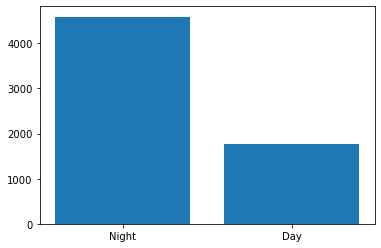

In [85]:
plt.bar(Data['Labels'].value_counts().index, Data['Labels'].value_counts().values)

Text(0.5, 1.0, 'Train')

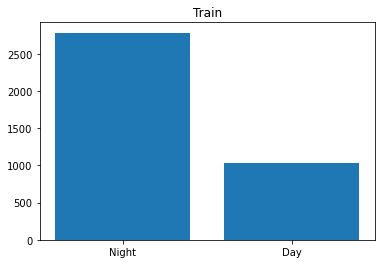

In [86]:
# set aside 20% of train and test data for evaluation
train, test = train_test_split(Data, test_size=0.2, shuffle = True)

# Use the same function above for the validation set
train, val = train_test_split(train, test_size=0.25, random_state= 8) # 0.25 x 0.8 = 0.2

plt.bar(train['Labels'].value_counts().index, train['Labels'].value_counts().values)
plt.title("Train")

Text(0.5, 1.0, 'Validation')

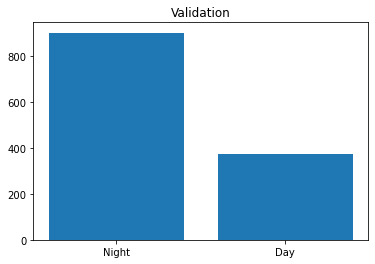

In [87]:
plt.bar(val['Labels'].value_counts().index, val['Labels'].value_counts().values)
plt.title("Validation")

Text(0.5, 1.0, 'Test')

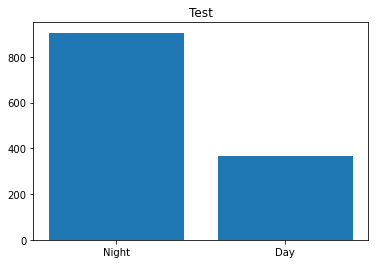

In [88]:
plt.bar(test['Labels'].value_counts().index, test['Labels'].value_counts().values)
plt.title("Test")

In [119]:
def prepare_data(data):
    data = data.reset_index()
    X = []
    Y = []
    for i in range(len(data)):
        img = cv2.imread(data.loc[i].at['Images'])
        img = cv2.resize(img, (224, 224))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype(np.float32)/255.
        if data.loc[i].at['Labels'] == 'Night':
            label = to_categorical(0, num_classes=2)
        else:
            label = to_categorical(1, num_classes=2)
        X.append(img)
        Y.append(label)
    return np.array(X), np.array(Y)

In [120]:
X_train, Y_train = prepare_data(train)
print(f"Number of training images: {len(X_train)}")

Number of training images: 3816


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [121]:
X_val, Y_val = prepare_data(val)
print(f"Number of validation images: {len(X_val)}")

Number of validation images: 1273


In [122]:
X_test, Y_test = prepare_data(test)
print(f"Number of validation images: {len(X_test)}")

Number of validation images: 1273


# Python Model From Scratch

In [125]:
model = Sequential()
model.add(Conv2D(32, (3,3), input_shape=(224, 224 ,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32, (3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dense(2))
model.add(Activation('softmax'))

2022-01-29 22:38:51.869670: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [129]:
batch_size = 32
nb_epochs = 6
nb_train_steps = X_train.shape[0]//batch_size
print(f"Number of training and validation steps = {nb_train_steps, len(X_val)}")

Number of training and validation steps = (119, 1273)


In [130]:
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

history = model.fit(X_train, Y_train, epochs=nb_epochs, steps_per_epoch=nb_train_steps, validation_data=(X_val, Y_val))

Epoch 1/6
119/119 [==============================] - 297s 2s/step - loss: 0.3192 - accuracy: 0.9297 - val_loss: 0.1286 - val_accuracy: 0.9607
Epoch 2/6
119/119 [==============================] - 263s 2s/step - loss: 0.1317 - accuracy: 0.9621 - val_loss: 0.1022 - val_accuracy: 0.9733
Epoch 3/6
119/119 [==============================] - 292s 2s/step - loss: 0.1079 - accuracy: 0.9756 - val_loss: 0.1050 - val_accuracy: 0.9654
Epoch 4/6
119/119 [==============================] - 290s 2s/step - loss: 0.0546 - accuracy: 0.9863 - val_loss: 0.0685 - val_accuracy: 0.9859
Epoch 5/6
119/119 [==============================] - 276s 2s/step - loss: 0.0559 - accuracy: 0.9877 - val_loss: 0.0877 - val_accuracy: 0.9851
Epoch 6/6
101/119 [========================>.....] - ETA: 41s - loss: 0.0344 - accuracy: 0.9924

WARNING - 2022-01-29 23:17:26,284 - data_adapter - Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 714 batches). You may need to use the repeat() function when building your dataset.


119/119 [==============================] - 251s 2s/step - loss: 0.0349 - accuracy: 0.9924 - val_loss: 0.0926 - val_accuracy: 0.9835


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [131]:
score = model.evaluate(X_test, Y_test)

40/40 [==============================] - 18s 440ms/step - loss: 0.0944 - accuracy: 0.9835


In [135]:
pred = model.predict(X_test)
pred = np.argmax(pred, axis=1)
labels = np.argmax(Y_test, axis=1)
print(classification_report(labels, pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       905
           1       0.97      0.97      0.97       368

    accuracy                           0.98      1273
   macro avg       0.98      0.98      0.98      1273
weighted avg       0.98      0.98      0.98      1273



In [136]:
model_json = model.to_json()
with open("Day_Or_Night_CNN_Model.json", "w") as json_file:
    json_file.write(model_json)

# Transfer Learning

In [137]:
def vgg16_model(num_classes=None):
    
    model = VGG16(weights= "imagenet", include_top = True, input_shape=(224, 224, 3))
    
    x= Dense(1024, activation='relu')(model.layers[-4].output)
    x= Dropout(0.7)(x)
    x= Dense(512, activation='relu')(x)
    x= Dropout(0.5)(x)
    x= Dense(2, activation='relu')(x)
    model = Model(model.input, x)
    
    return model

In [139]:
vgg_conv = vgg16_model(2)
for layer in vgg_conv.layers[:10]:
    layer.trainable = False

In [147]:
opt = Adam(lr=0.0001, decay=1e-5)
vgg_conv.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [148]:
history = vgg_conv.fit(X_train, Y_train, epochs=nb_epochs, steps_per_epoch=nb_train_steps, validation_data=(X_val, Y_val), class_weight={0:1, 1:2.5})

Epoch 1/6


KeyboardInterrupt: 

In [ ]:
loss, acc = vgg_conv.evaluate(X_test, Y_test, batch_size= 32)
print(f'Loss = {loss}\nAccuracu = {acc}' )

In [ ]:
pred = vgg_conv.predict(X_test)
pred = np.argmax(pred, axis=1)
labels = np.argmax(Y_test, axis=1)
print(classification_report(labels, pred))

In [ ]:
cm = confusion_matrix(labels, pred)
sns.heatmap(cm, annot=True, fmt='g', xticklabels=['Night', 'Day'], yticklabels=['Night', 'Day'])